# Set Up Spark

In [1]:
# Set up Spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.mirrors.hoobly.com/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install py4j

!export JAVA_HOME=$(/usr/lib/jvm/java-8-openjdk-amd64 -v 1.8)
! echo $JAVA_HOME
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
import findspark
findspark.init("spark-2.4.5-bin-hadoop2.7")# SPARK_HOME

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

/bin/bash: /usr/lib/jvm/java-8-openjdk-amd64: Is a directory



In [2]:
!ls

movies			       spark-2.4.5-bin-hadoop2.7.tgz.1
sample_data		       spark-2.4.5-bin-hadoop2.7.tgz.2
spark-2.4.5-bin-hadoop2.7      spark-2.4.5-bin-hadoop2.7.tgz.3
spark-2.4.5-bin-hadoop2.7.tgz


In [3]:
spark.version

'2.4.5'

# Import Library

In [75]:
pip install elasticsearch

     |████████████████████████████████| 102kB 2.6MB/s 


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline
from IPython.display import Image, HTML, display
from elasticsearch import Elasticsearch

#Part0:Abstract 

In this project, we build a recommender engine using Apache Spark and Elasticsearch. The recommendation model is trained in Spark using matrix factorization method and alternating least squares technique. Elasticsearch (and its vector scoring plugin) is used to persist the trained model, query, score, rank, and display results, such as the movies that certain users may find interesting. We also use The Movie Database (TMdb) API to dislay recommended movie posters to the user.



# Part 1: Data ETL and Data Exploration

## Read Data from your machine






In [5]:
'''
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  '''


'\nfrom google.colab import files\n\nuploaded = files.upload()\n\nfor fn in uploaded.keys():\n  print(\'User uploaded file "{name}" with length {length} bytes\'.format(\n      name=fn, length=len(uploaded[fn])))\n  '

In [6]:
import os 
os.listdir('./movies')

['ratings.csv', 'movies.csv', 'links.csv', 'tags.csv']

In [0]:
ratings_df = spark.read.csv('./movies/ratings.csv',inferSchema=True, header =True)
movies_df = spark.read.csv('./movies/movies.csv',inferSchema=True, header =True)
links_df = spark.read.csv('./movies/links.csv',inferSchema=True, header =True)
tags_df = spark.read.csv('./movies/tags.csv',inferSchema=True, header =True)

In [8]:
ratings_df.printSchema()
movies_df.printSchema()
tags_df.printSchema()
links_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- tag: string (nullable = true)
 |-- timestamp: integer (nullable = true)

root
 |-- movieId: integer (nullable = true)
 |-- imdbId: integer (nullable = true)
 |-- tmdbId: integer (nullable = true)



**Check null in each table.**


In [89]:
print("If there is missing data in each table?")
print('movie_df: {}'.format(movies_df.count() == movies_df.na.drop().count()))
print('ratings_df: {}'.format(ratings_df.count() == ratings_df.na.drop().count()))
print('links_df: {}'.format(links_df.count() == links_df.na.drop().count()))
print('tags_df: {}'.format(tags_df.count() == tags_df.na.drop().count()))

If there is missing data in each table?
movie_df: True
ratings_df: True
links_df: False
tags_df: True


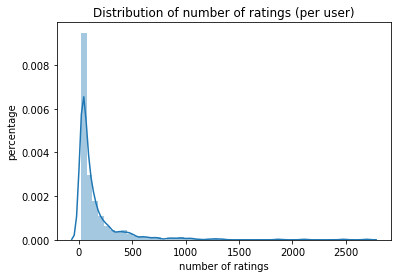

In [90]:
# get statistics for users
users_result = ratings_df.groupBy("userId").count()\
.orderBy('count', ascending=False)

fig = plt.figure()
tmp=sns.distplot(users_result.toPandas()['count'], hist=True)
plt.ylabel('percentage')
plt.xlabel('number of ratings')
tmp.set_title('Distribution of number of ratings (per user)')
display(tmp)


In [91]:
users_result.toPandas().head(5)

,userId,count
0,414,2698
1,599,2478
2,474,2108
3,448,1864
4,274,1346


##Movies' information


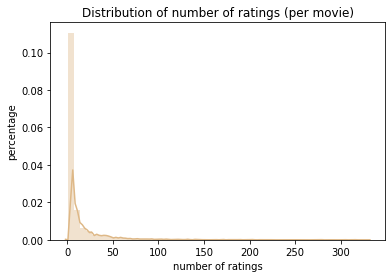

In [92]:
movies_result=ratings_df.groupBy("movieId").count()\
.orderBy('count', ascending=False)

fig = plt.figure()
tmp=sns.distplot(movies_result.toPandas()['count'], color = 'burlywood', hist=True)
plt.ylabel('percentage')
plt.xlabel('number of ratings')
tmp.set_title('Distribution of number of ratings (per movie)')
display(tmp)

In [93]:
movies_result.toPandas().head(5)

,movieId,count
0,356,329
1,318,317
2,296,307
3,593,279
4,2571,278


In [94]:
movies_result.toPandas().describe()

,movieId,count
count,9724.000000,9724.000000
mean,42245.024373,10.369807
std,52191.137320,22.401005
min,1.000000,1.000000
25%,3245.500000,1.000000
50%,7300.000000,3.000000
75%,76739.250000,9.000000
max,193609.000000,329.000000


## Rating's information


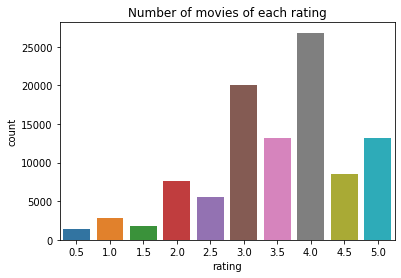

In [95]:
## get statistics for ratings
ratings_result=ratings_df.groupBy('rating').count()\
.withColumn('rating', ratings_df.rating.cast('float'))\
.toPandas()

fig = plt.figure()
tmp=sns.barplot(x='rating', y='count', data=ratings_result)
tmp.set_title('Number of movies of each rating')
display(tmp)

## Unrated movies

In [96]:
rated_list=ratings_df.select(ratings_df.movieId)\
.where('rating is not null')\
.withColumnRenamed('movieId', 'rated').distinct()

unrated_list=movies_df.join(rated_list, movies_df.movieId==rated_list.rated, "left_outer")\
.where('rated is null')

print('{} movies are unrated, {} movies are rated'.format(unrated_list.count(), rated_list.count()))

unrated_list.toPandas().fillna('No')

18 movies are unrated, 9724 movies are rated


,movieId,title,genres,rated
0,1076,"Innocents, The (1961)",Drama|Horror|Thriller,No
1,2939,Niagara (1953),Drama|Thriller,No
2,3338,For All Mankind (1989),Documentary,No
3,3456,"Color of Paradise, The (Rang-e khoda) (1999)",Drama,No
4,4194,I Know Where I'm Going! (1945),Drama|Romance|War,No
5,5721,"Chosen, The (1981)",Drama,No
6,6668,"Road Home, The (Wo de fu qin mu qin) (1999)",Drama|Romance,No
7,6849,Scrooge (1970),Drama|Fantasy|Musical,No
8,7020,Proof (1991),Comedy|Drama|Romance,No
9,7792,"Parallax View, The (1974)",Thriller,No


## Sparsity

In [97]:
## compute sparsity
tmp=ratings_df.count()
print('sparsity is: {}'.format(1-tmp/9724/610))

sparsity is: 0.9830003169443864


## Spark SQL and OLAP


In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import col, mean, udf, lit, current_timestamp, unix_timestamp, array_contains
from pyspark.sql import functions as F
from pyspark.sql import SQLContext

Q1: The number of Users

In [10]:
ratings_df.select('UserId').distinct().count()

610


Q2: The number of Movies

In [11]:
movies_df.select('movieID').distinct().count()

9742

Q3: How many movies are rated by users? List movies not rated before

In [12]:
ratings_df.select('movieId').distinct().count()

9724

In [13]:
ratings_df.createOrReplaceTempView("ratings_view")
movies_df.createOrReplaceTempView("movies_view")

# List movies not rated before
spark.sql(
    '''SELECT DISTINCT movieID 
       FROM movies_view 
       WHERE movieID NOT IN (SELECT DISTINCT movieID FROM ratings_view)
    ''').show()



+-------+
|movieID|
+-------+
|   3456|
|   2939|
|   7020|
|   6668|
|   7792|
|  26085|
|  34482|
|  32160|
|  30892|
|   6849|
|   1076|
|  85565|
|   3338|
|  25855|
|   4194|
|   8765|
|   5721|
|  32371|
+-------+



Q4: List Movie Genres

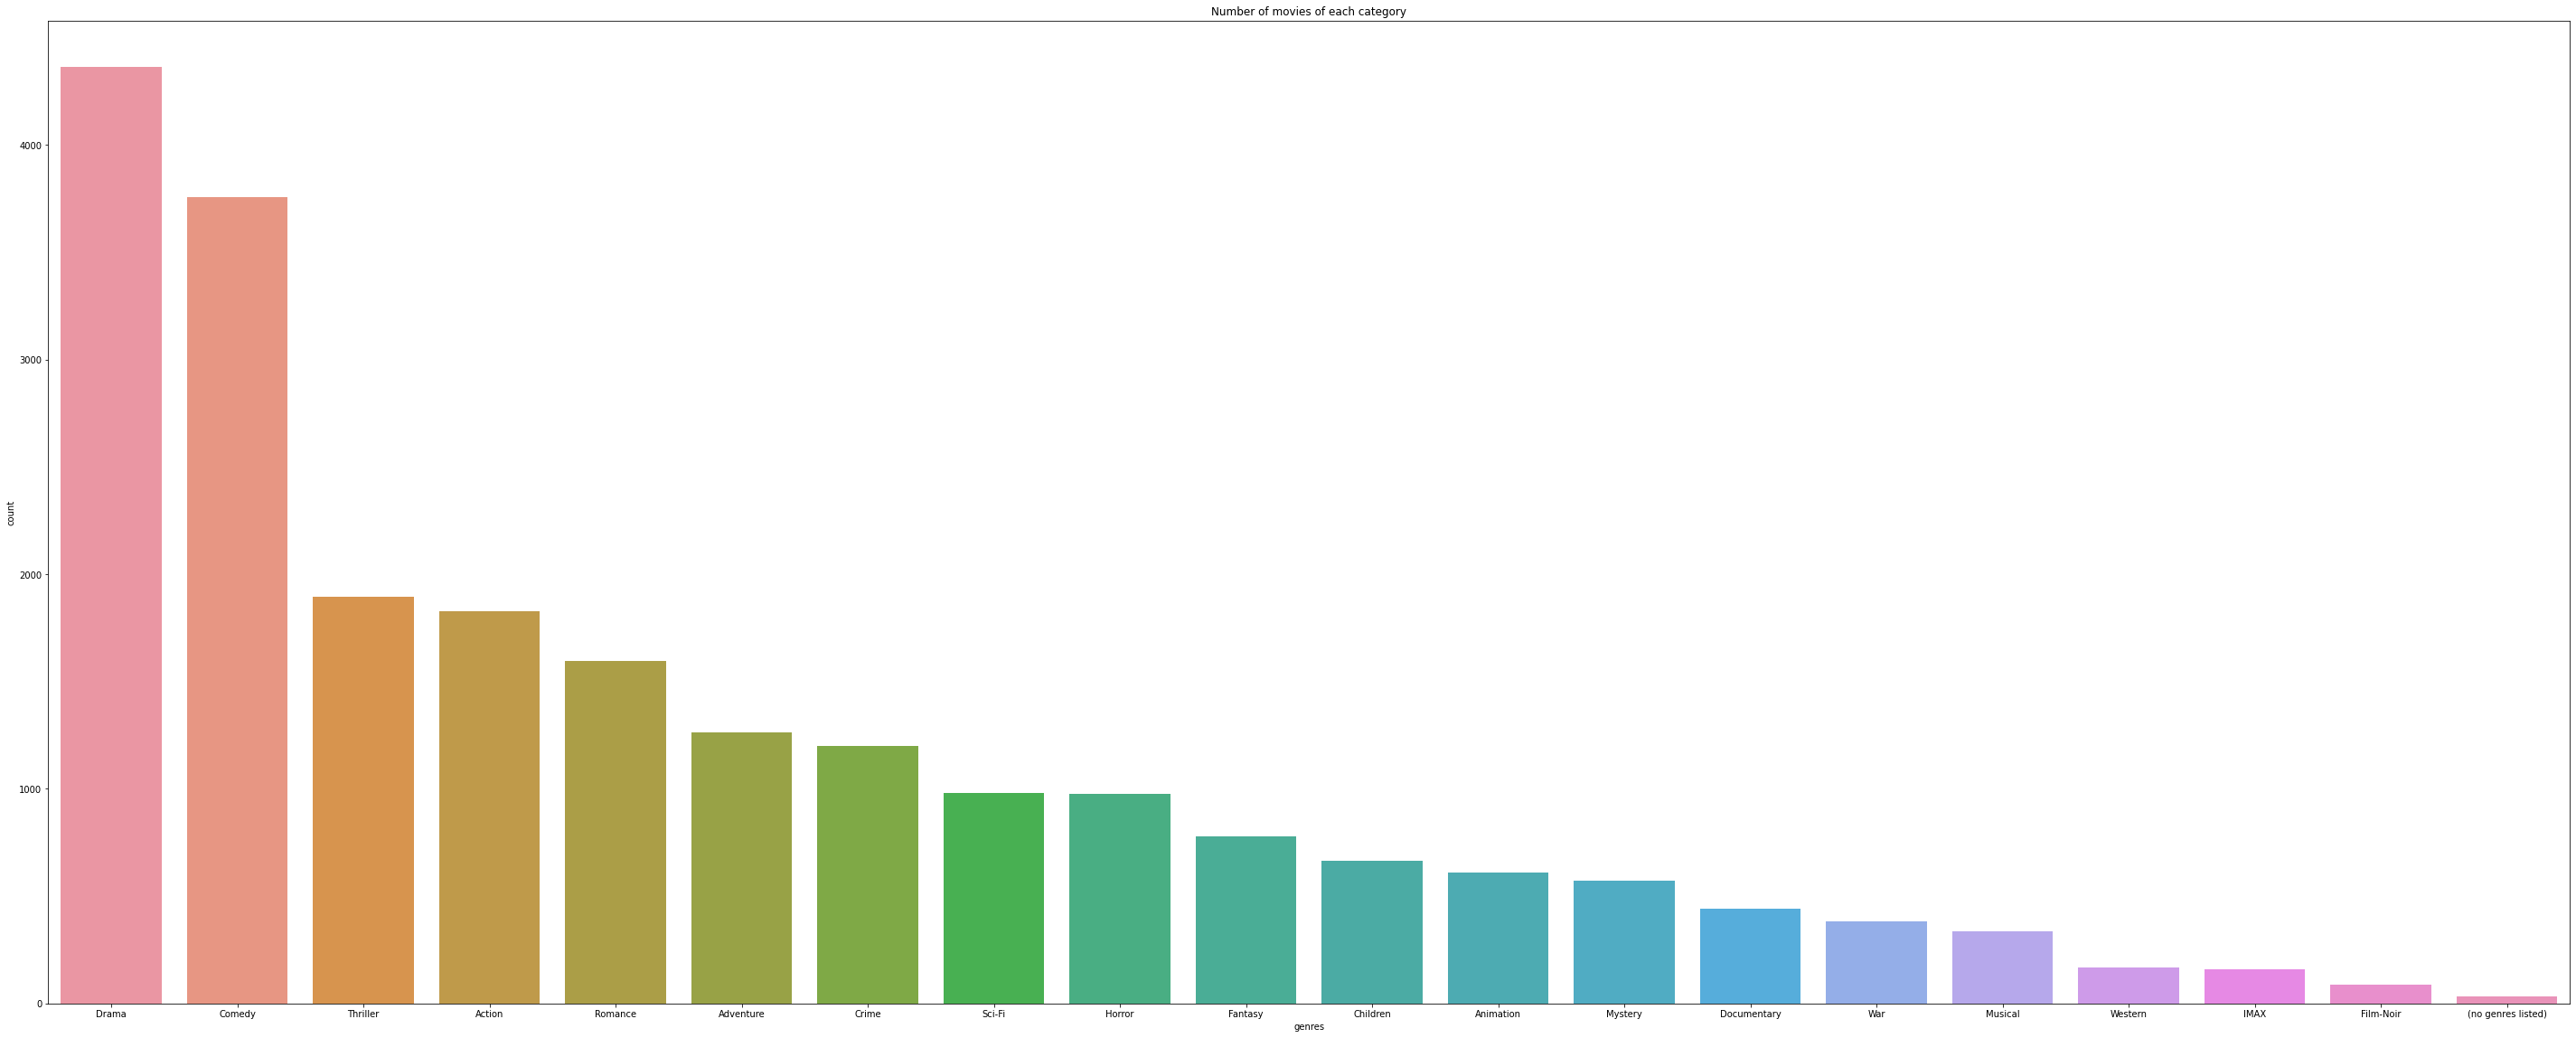

In [14]:
movies_genres_temp=movies_df.where('genres is not null')\
.select('title', F.explode(F.split('genres', '\|'))\
.alias('genres'))

movies_genres=movies_genres_temp.groupBy('genres').count()\
.orderBy('count', ascending=False)\
.toPandas()

plt.figure(figsize=(50,20))
tmp=sns.barplot(x='genres', y='count', data=movies_genres)
tmp.set_title('Number of movies of each category')
display(tmp)

Q5: Movie for Each Category

In [15]:
movies_genres_title=movies_genres_temp.groupBy('genres')\
.agg(F.collect_list("title")\
.alias('titles'))

movies_genres_title.show()

+------------------+--------------------+
|            genres|              titles|
+------------------+--------------------+
|             Crime|[Heat (1995), Cas...|
|           Romance|[Grumpier Old Men...|
|          Thriller|[Heat (1995), Gol...|
|         Adventure|[Toy Story (1995)...|
|             Drama|[Waiting to Exhal...|
|               War|[Richard III (199...|
|       Documentary|[Nico Icon (1995)...|
|           Fantasy|[Toy Story (1995)...|
|           Mystery|[Copycat (1995), ...|
|           Musical|[Pocahontas (1995...|
|         Animation|[Toy Story (1995)...|
|         Film-Noir|[Devil in a Blue ...|
|(no genres listed)|[La cravate (1957...|
|              IMAX|[Apollo 13 (1995)...|
|            Horror|[Dracula: Dead an...|
|           Western|[Desperado (1995)...|
|            Comedy|[Toy Story (1995)...|
|          Children|[Toy Story (1995)...|
|            Action|[Heat (1995), Sud...|
|            Sci-Fi|[Powder (1995), C...|
+------------------+--------------

## Explore data for distribution

In [16]:
ratings_count=ratings_df.groupBy('rating').count()\
.orderBy('rating', ascending=True)\
.toPandas()

display(ratings_count)

,rating,count
0,0.5,1370
1,1.0,2811
2,1.5,1791
3,2.0,7551
4,2.5,5550
5,3.0,20047
6,3.5,13136
7,4.0,26818
8,4.5,8551
9,5.0,13211


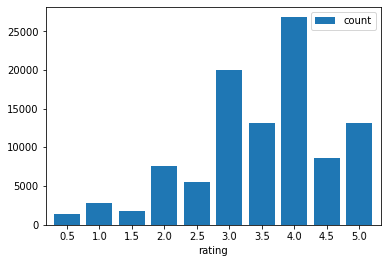

In [17]:
ratings_count.plot(kind ='bar',x = 'rating',y='count',rot = True,width = 0.8)

The most common socre is 4.0 and the rarest score is 0.5.

We can also get average score of a specfic movie,

In [37]:
# average rating of movies
ratings_df.groupBy('MovieID').agg(mean('rating')).toPandas().head()

,MovieID,avg(rating)
0,1580,3.487879
1,2366,3.640000
2,3175,3.580000
3,1088,3.369048
4,32460,4.250000


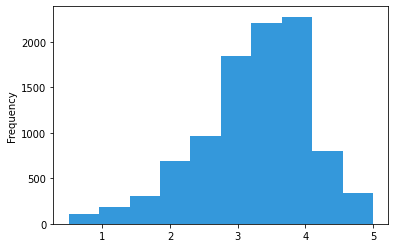

In [39]:
# average rating of movies
ratings_df.groupBy('MovieID').agg(mean('rating')).toPandas()['avg(rating)'].plot(kind='hist', color='#3498db')
plt.savefig('fig_002.png', dpi=600)

In [41]:
# average rating from users
ratings_df.groupBy('userID').agg(mean('rating')).toPandas().head()

,userID,avg(rating)
0,148,3.739583
1,463,3.787879
2,471,3.875000
3,496,3.413793
4,243,4.138889


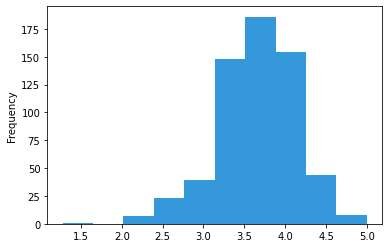

In [43]:
# average rating from users
ratings_df.groupBy('userID').agg(mean('rating')).toPandas()['avg(rating)'].plot(kind='hist', color='#3498db')
plt.savefig('fig_003.png', dpi=600)

The file movies.csv contains the movieId, title and genres for each movie. As you can see, the genres field is a bit tricky to use, as the genres are in the form of one string delimited by the | character: Adventure|Animation|Children|Comedy|Fantasy.

In [44]:
print("Raw movie data:")
movies_df.show(5, truncate=False)

Raw movie data:
+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows



Create a DataFrame user-defined function (UDF) to extract this delimited string into a list of genres.

In [46]:
# define a UDF to convert the raw genres string to an array of genres and lowercase
extract_genres = udf(lambda x: x.lower().split("|"), ArrayType(StringType()))
# test it out
movies_df.select("movieId", "title", extract_genres("genres").alias("genres")).show(5, False)

+-------+----------------------------------+-------------------------------------------------+
|movieId|title                             |genres                                           |
+-------+----------------------------------+-------------------------------------------------+
|1      |Toy Story (1995)                  |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji (1995)                    |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men (1995)           |[comedy, romance]                                |
|4      |Waiting to Exhale (1995)          |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II (1995)|[comedy]                                         |
+-------+----------------------------------+-------------------------------------------------+
only showing top 5 rows



Ok, that looks better!

You may also notice that the movie titles contain the year of release. It would be useful to have that as a field in your search index for filtering results (say you want to filter our recommendations to include only more recent movies).

Create a UDF to extract the release year from the title using a Python regular expression.

In [54]:
import re
# define a UDF to extract the release year from the title, and return the new title and year in a struct type
def extract_year_fn(title):
    result = re.search("\(\d{4}\)", title)
    try:
        if result:
            group = result.group()
            year = group[1:-1]
            start_pos = result.start()
            title = title[:start_pos-1]
            return (title, year)
        else:
            return (title, 1970)
    except:
        print(title)

extract_year = udf(extract_year_fn,\
                   StructType([StructField("title", StringType(), True),\
                               StructField("release_date", StringType(), True)]))
    
# test out our function
s = "Jumanji (1995)"
extract_year_fn(s)

('Jumanji', '1995')

Ok the function works! Now create a new DataFrame with the cleaned-up titles, release dates and genres of the movies.

In [56]:
movies = movies_df.select(
    "movieId", extract_year("title").title.alias("title"),\
    extract_year("title").release_date.alias("release_date"),\
    extract_genres("genres").alias("genres"))

print("Cleaned movie data:")
movies.show(5, truncate=False)

Cleaned movie data:
+-------+---------------------------+------------+-------------------------------------------------+
|movieId|title                      |release_date|genres                                           |
+-------+---------------------------+------------+-------------------------------------------------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |
+-------+---------------------------+------------+-------------------------------------------------+
only showing top 5 rows



Next, join the links.csv data to movies so that there is an id for The Movie Database corresponding to each movie. You can use this id to retrieve movie poster images when displaying your recommendations later.

In [59]:
# join movies with links to get TMDB id
movie_data = movies.join(links_df, movies.movieId == links_df.movieId)\
    .select(movies.movieId, movies.title, movies.release_date, movies.genres, links_df.tmdbId)

num_movies = movie_data.count()

print("Cleaned movie data with tmdbId links:")
movie_data.show(5, truncate=False)

Cleaned movie data with tmdbId links:
+-------+---------------------------+------------+-------------------------------------------------+------+
|movieId|title                      |release_date|genres                                           |tmdbId|
+-------+---------------------------+------------+-------------------------------------------------+------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|862   |
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |8844  |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |15602 |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |31357 |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |11862 |
+-------+---------------------------+------------+------------------------------------------------

Display movie posters using TMDb API

Run the below cell to test your access to TMDb API. You should see the Toy Story movie poster displayed inline.

To install the Python package run pip install tmdbsimple

Replace [YOUR KEY] below with your TMDb API key.

In [64]:
pip install tmdbsimple

In [69]:
try:
    import tmdbsimple as tmdb
    # replace this variable with your actual TMdb API key
    tmdb.API_KEY = 'd36bba783fd1a1676e9ecfbcc6729bea'
    print("Successfully imported tmdbsimple!")
    # base URL for TMDB poster images
    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
    movie_id = movie_data.first().tmdbId
    movie_info = tmdb.Movies(movie_id).info()
    movie_poster_url = IMAGE_URL + movie_info['poster_path']
    display(Image(movie_poster_url, width=200))
except Exception:
    print("Cannot import tmdbsimple, no movie posters will be displayed!")

Successfully imported tmdbsimple!
Cannot import tmdbsimple, no movie posters will be displayed!


# Part2: Spark ALS based approach for training model

We will use an Spark ML to predict the ratings, so let's reload "ratings.csv" using sc.textFile and then convert it to the form of (user, item, rating) tuples.

In [0]:
new_ratings_df = spark.read.csv('./movies/ratings.csv',inferSchema=True, header =True)

In [19]:
new_ratings_df.count()

100836

In [20]:
movie_ratings=new_ratings_df.drop('timestamp')
movie_ratings.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
|     1|    163|   5.0|
|     1|    216|   5.0|
|     1|    223|   3.0|
|     1|    231|   5.0|
|     1|    235|   4.0|
|     1|    260|   5.0|
|     1|    296|   3.0|
|     1|    316|   3.0|
|     1|    333|   5.0|
|     1|    349|   4.0|
+------+-------+------+
only showing top 20 rows



In [21]:
movie_ratings.printSchema() 

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)



In [0]:
# Data type convert
from pyspark.sql.types import IntegerType, FloatType
movie_ratings = movie_ratings.withColumn("userId", movie_ratings["userId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("movieId", movie_ratings["movieId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("rating", movie_ratings["rating"].cast(FloatType()))

In [23]:
movie_ratings.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
|     1|    163|   5.0|
|     1|    216|   5.0|
|     1|    223|   3.0|
|     1|    231|   5.0|
|     1|    235|   4.0|
|     1|    260|   5.0|
|     1|    296|   3.0|
|     1|    316|   3.0|
|     1|    333|   5.0|
|     1|    349|   4.0|
+------+-------+------+
only showing top 20 rows



## ALS Model Selection and Evaluation
With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [0]:
# import package
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder
from pyspark.sql import Row

In [0]:
#Create test and train set
(training,test)=movie_ratings.randomSplit([0.8,0.2])

In [0]:
#Create ALS model
# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5, rank=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(training)

In [27]:
# #Fit ALS model to training data
# Define evaluator as RMSE
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 1.1002356710845504


In [0]:
#Tune model using ParamGridBuilder
paramGrid = ParamGridBuilder()\
            .addGrid(als.regParam, [0.1, 0.01, 0.001])\
            .addGrid(als.maxIter, [1, 3, 5])\
            .addGrid(als.rank, [5, 10, 15])\
            .build()

In [0]:
# Define evaluator as RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

In [0]:
# Build Cross validation 
crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)  

In [0]:
#Fit ALS model to training data
model = als.fit(training)

In [32]:
#Extract best model from the tuning exercise using ParamGridBuilder
cvModel = crossval.fit(training)
predictions = cvModel.transform(training)
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.655479548057451


In [0]:
#Generate predictions and evaluate using RMSE
best_model = cvModel.bestModel
predictions=best_model.transform(test)
rmse = evaluator.evaluate(predictions)

In [34]:
#Print evaluation metrics and model parameters
print ("RMSE = "+str(rmse))
print ("**Best Model**")
print (" Rank:"+str(best_model._java_obj.parent().getRank()))
print (" MaxIter:"+str(best_model._java_obj.parent().getMaxIter()))
print (" RegParam:"+str(best_model._java_obj.parent().getRegParam()))

RMSE = 0.8934168977148971
**Best Model**
 Rank:5
 MaxIter:5
 RegParam:0.1


## Model Testing
And finally, make a prediction and check the testing error.

In [102]:
#Generate predictions and evaluate using RMSE
predictions=best_model.transform(test)
rmse = evaluator.evaluate(predictions)
print ("RMSE = "+str(rmse))

RMSE = 0.8934168977148971


### Re-fitting

In [0]:
# re-fitting using best parameters and whole data set
MR_ALS = ALS(maxIter=5, regParam=0.01, rank=5,userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
best_model=MR_ALS.fit(movie_ratings)


### All Data

In [105]:
#extract all data
alldata=best_model.transform(movie_ratings)
rmse = evaluator.evaluate(alldata)
print ("RMSE = "+str(rmse))

#round predictions to 0.5
alldata=alldata.withColumn('rounded_predictions', F.round(F.col('prediction')*2)/2)
alldata_temp=alldata.toPandas()
alldata_temp.head()

RMSE = 0.6433114451517846


,userId,movieId,rating,prediction,rounded_predictions
0,191,148,5.0,5.299272,5.5
1,133,471,4.0,3.266256,3.5
2,597,471,2.0,4.355469,4.5
3,385,471,4.0,3.597659,3.5
4,436,471,3.0,3.226183,3.0


Text(0.5, 0.92, 'Actual & predicted rating by users and movie ID')

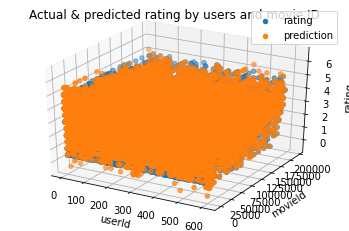

In [108]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x=alldata_temp['userId']
y=alldata_temp['movieId']
z=alldata_temp['rating']
z1=alldata_temp['rounded_predictions']
ax.scatter(x, y, z, label='rating')
ax.scatter(x, y, z1, label='prediction')
ax.legend()
ax.set_xlabel('userId')
ax.set_ylabel('movieId')
ax.set_zlabel('rating')
ax.set_title('Actual & predicted rating by users and movie ID')

##Application and Performance

### For the movie with most number of ratings

In [0]:
#plot actual and predicted ratings for movie with most number of ratings
movie_rated_most=alldata.where('movieId = 356').select('rating', 'rounded_predictions').orderBy('rating')

In [110]:
RMSE_evaluator_rounded = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="rounded_predictions")
print(RMSE_evaluator_rounded.evaluate(movie_rated_most))

0.7360661064536995


In [0]:
movie_rated_most=movie_rated_most.toPandas()

In [112]:
abs(movie_rated_most.rounded_predictions-movie_rated_most.rating).mean()

0.5638297872340425

Text(0.5, 1.0, 'Actual & predicted ratings for movie with 329 ratings')

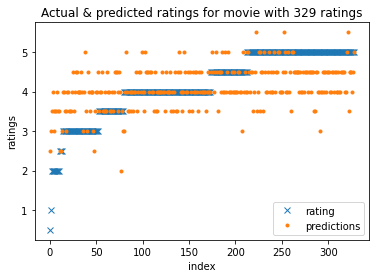

In [114]:
fig = plt.figure()
plt.plot(movie_rated_most.index, movie_rated_most.rating, 'x', label='rating')
plt.plot(movie_rated_most.index, movie_rated_most.rounded_predictions, '.', label='predictions')
plt.xlabel('index')
plt.ylabel('ratings')
plt.legend()
plt.title('Actual & predicted ratings for movie with 329 ratings')

### Movie with only one rating

In [0]:
#plot actual and predicted ratings for movie with 1 ratings
movie_rated_least=alldata.join(movies_result, movies_result.movieId==alldata.movieId, 'left')\
.where('count=1').select('rating', 'rounded_predictions').orderBy('rating')

In [116]:
print(RMSE_evaluator_rounded.evaluate(movie_rated_least))

0.06542419288389865


In [0]:
movie_rated_least=movie_rated_least.toPandas()


Text(0.5, 1.0, 'Actual & predicted ratings for movies with 1 ratings')

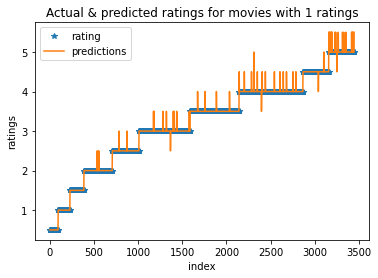

In [119]:
fig = plt.figure()
plt.plot(movie_rated_least.index, movie_rated_least.rating, '*', label='rating')
plt.plot(movie_rated_least.index, movie_rated_least.rounded_predictions, '-', label='predictions')
plt.xlabel('index')
plt.ylabel('ratings')
plt.legend()
plt.title('Actual & predicted ratings for movies with 1 ratings')

##User rated most movies

In [0]:
#plot actual and predicted ratings for most active user
user_rate_most=alldata.where('userId = 414').select('rating', 'rounded_predictions').orderBy('rating')

In [121]:
print(RMSE_evaluator_rounded.evaluate(user_rate_most))

0.55339440450593


In [0]:
user_rate_most=user_rate_most.toPandas()

Text(0.5, 1.0, 'Actual & predicted ratings for user rated 2698 movies')

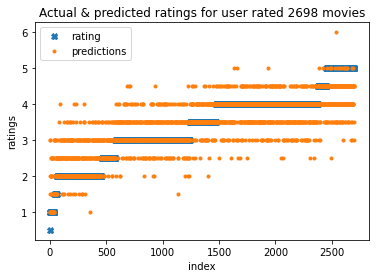

In [124]:
fig = plt.figure()
plt.plot(user_rate_most.index, user_rate_most.rating, 'X', label='rating')
plt.plot(user_rate_most.index, user_rate_most.rounded_predictions, '.', label='predictions')
plt.xlabel('index')
plt.ylabel('ratings')
plt.legend()
plt.title('Actual & predicted ratings for user rated 2698 movies')

##Find general threshold for numbers of ratings to stable prediction

In [0]:
#plot average abs error by each movie and number of ratings
average_by_movie=alldata.groupBy('movieId')\
.agg(F.mean(F.abs(alldata.rating-alldata.rounded_predictions)).alias('MEBM'), F.count('rating').alias('number_of_users_rated'))\
.orderBy('MEBM', ascending=False)

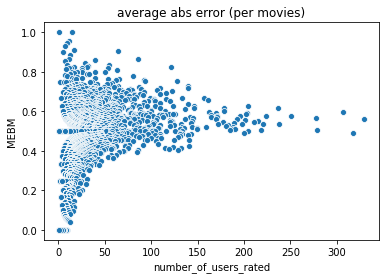

In [126]:
tmp=average_by_movie.toPandas()
fig = plt.figure()
tmp=sns.scatterplot(x='number_of_users_rated', y='MEBM', data=tmp)
tmp.set_title('average abs error (per movies)')
display(tmp)

In [0]:
#plot average abs error by number of ratings
average_by_rating_number=alldata.join(movies_result, movies_result.movieId==alldata.movieId, 'left')\
.groupBy('count')\
.agg(F.mean(F.abs(alldata.rating-alldata.rounded_predictions)).alias('MEBC'))\
.orderBy('count', ascending=False)

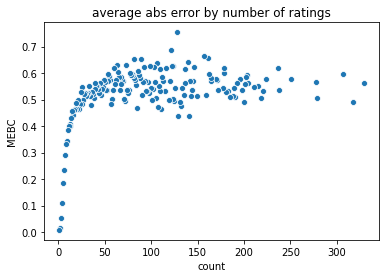

In [130]:
tmp=average_by_rating_number.toPandas()
fig = plt.figure()
tmp=sns.scatterplot(x='count', y='MEBC', data=tmp)
tmp.set_title('average abs error by number of ratings')
display(tmp)

# 新段落

# Part3:Practical Use Example of the model

## Recommend moive to users with id: 575, 232.
you can choose some users to recommend the moives

In [131]:
user_list=set(['575', '232'])

recommend_for_all=best_model.recommendForAllUsers(5)

recommend_5=recommend_for_all.where(recommend_for_all.userId.isin(user_list))\
.select('userId', F.explode('recommendations'))\
.select('userId', F.col('col').movieId.alias('movieId'), F.col('col').rating.alias('rating'))

recommend_5=recommend_5.join(movies_df, recommend_5.movieId==movies_df.movieId, 'left')\
.select('userId', movies_df.movieId, 'title','genres')

recommend_5=recommend_5.join(movies_result, recommend_5.movieId==movies_result.movieId, 'left')

recommend_5.show()

+------+-------+--------------------+--------------------+-------+-----+
|userId|movieId|               title|              genres|movieId|count|
+------+-------+--------------------+--------------------+-------+-----+
|   232|   5034|Truly, Madly, Dee...|       Drama|Romance|   5034|    3|
|   232|   3200|Last Detail, The ...|        Comedy|Drama|   3200|    8|
|   232|  84847|         Emma (2009)|Comedy|Drama|Romance|  84847|    2|
|   232|   2771|Brokedown Palace ...|               Drama|   2771|    4|
|   232|   8477|    Jetée, La (1962)|      Romance|Sci-Fi|   8477|    2|
|   575|  49932|Inland Empire (2006)|Drama|Mystery|Thr...|  49932|    6|
|   575|  46572|       Edmond (2005)|      Drama|Thriller|  46572|    3|
|   575|   6993|Hannah and Her Si...|Comedy|Drama|Romance|   6993|   13|
|   575|  48322|Jackass Number Tw...|  Comedy|Documentary|  48322|    7|
|   575|   6375|Gigantic (A Tale ...|         Documentary|   6375|    4|
+------+-------+--------------------+--------------

## Find the similar moives for moive with id: 463, 471
You can find the similar moives based on the ALS results

In [132]:
all_movie_id=ratings_df.select('movieId').distinct()
is_rated=all_movie_id.where('movieId=471').count()==1

print('Movie with id 471 was rated? {}'.format(is_rated))

Movie with id 471 was rated? True


In [0]:
tmp_compare=best_model.itemFactors

compare=tmp_compare.select('id', 'features').where('id = 471').withColumnRenamed('id', 'id1').withColumnRenamed('features', 'f1')\
.crossJoin(tmp_compare.select('id', 'features').where('id != 471').withColumnRenamed('id', 'id2').withColumnRenamed('features', 'f2'))

In [0]:
def cos_sim(a,b):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))
cosine=udf(cos_sim, FloatType())

In [138]:
result=compare.withColumn('similarity', cosine(F.col('f1'), F.col('f2'))).where('similarity>0.99').orderBy('similarity', ascending=False)
result=result.join(movies_df, movies_df.movieId==result.id2,'left').select('title','genres')
result.show()

+--------------------+--------------------+
|               title|              genres|
+--------------------+--------------------+
|Sense and Sensibi...|       Drama|Romance|
|Michael Collins (...|               Drama|
|King of Comedy, T...|        Comedy|Drama|
|     Car Wash (1976)|              Comedy|
|Moscow on the Hud...|        Comedy|Drama|
|   Annie Hall (1977)|      Comedy|Romance|
|Royal Tenenbaums,...|        Comedy|Drama|
|Porco Rosso (Crim...|Adventure|Animati...|
|    Gallipoli (1981)|           Drama|War|
| Hustler, The (1961)|               Drama|
+--------------------+--------------------+



## movie ID:463

## Special Groups

In [0]:
average_by_user=alldata.groupBy('userId')\
.agg(F.mean(F.abs(alldata.rating-alldata.rounded_predictions)).alias('MEBU'), F.count('rating').alias('number_of_movies_rated'))\
.orderBy('MEBU', ascending=False)

In [140]:
average_by_user.where('MEBU>0.5').show()

+------+------------------+----------------------+
|userId|              MEBU|number_of_movies_rated|
+------+------------------+----------------------+
|   542|0.8672566371681416|                   113|
|   328|0.8509803921568627|                   255|
|   393|0.8211382113821138|                   123|
|   399|0.8194444444444444|                    36|
|   197|               0.8|                    35|
|   517|              0.79|                   400|
|   160|0.7757437070938215|                   437|
|   174|0.7686567164179104|                    67|
|   136|0.7612612612612613|                   111|
|   308|0.7608695652173914|                   115|
|   153|0.7597765363128491|                   179|
|   301|              0.75|                   114|
|    76|0.7394957983193278|                   119|
|   598|0.7380952380952381|                    21|
|   500|0.7325581395348837|                    86|
|   259|0.7241379310344828|                    29|
|   396|0.7142857142857143|    